In [1]:
import random, numpy as np
import math
import torch, torch.nn as nn, torch.nn.functional as F

def set_seed(seed):
    torch.use_deterministic_algorithms(True)  # Ensures deterministic behavior
    torch.manual_seed(seed)  # Seed for PyTorch (CPU)
    torch.cuda.manual_seed(seed)  # Seed for PyTorch (single GPU)
    torch.cuda.manual_seed_all(seed)  # Seed for PyTorch (all GPUs, if applicable)
    np.random.seed(seed)  # Seed for NumPy
    random.seed(seed)  # Seed for Python random
    # For compatibility with older PyTorch versions:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
from tqdm import tqdm
from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Load the MNIST training set
mnist_data = datasets.MNIST("../", download=False, train=True,
                              transform=transforms.ToTensor())

# Load the MNIST test set
mnist_test = datasets.MNIST("../", download=False, train=False,
                              transform=transforms.ToTensor())

# Split dataset into training and validation and create data loaders
batch_size = 256
ds_train, ds_val = torch.utils.data.random_split(mnist_data, [int(0.8 * len(mnist_data)), len(mnist_data) - int(0.8 * len(mnist_data))])

In [ ]:
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class LeNet5BatchNorm(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5BatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.bn1 = nn.BatchNorm2d((6), affine=True)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d((16), affine=True)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.bn3 = nn.BatchNorm1d(120, affine=True)
        self.fc2 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84, affine=True)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16*4*4)
        x = F.relu(self.bn3(self.fc1(x)))
        x = F.relu(self.bn4(self.fc2(x)))
        x = self.fc3(x)
        return x

class LeNet5RMSNorm(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5RMSNorm, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.bn1 = nn.RMSNorm((6, 24, 24), elementwise_affine=True)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.RMSNorm((16, 8, 8), elementwise_affine=True)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.bn3 = nn.RMSNorm((120), elementwise_affine=True)
        self.fc2 = nn.Linear(120, 84)
        self.bn4 = nn.RMSNorm((84), elementwise_affine=True)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16*4*4)
        x = F.relu(self.bn3(self.fc1(x)))
        x = F.relu(self.bn4(self.fc2(x)))
        x = self.fc3(x)
        return x

class LeNet5InstanceNorm(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5InstanceNorm, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.bn1 = nn.InstanceNorm2d((6), affine=True)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.InstanceNorm2d((16), affine=True)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.bn3 = nn.LayerNorm(120, elementwise_affine=True)
        self.fc2 = nn.Linear(120, 84)
        self.bn4 = nn.LayerNorm(84, elementwise_affine=True)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16*4*4)
        x = F.relu(self.bn3(self.fc1(x)))
        x = F.relu(self.bn4(self.fc2(x)))
        x = self.fc3(x)
        return x

class LoRA2d(nn.Module):
    """
    A Conv2d layer with an added LoRA (Low-Rank Adaptation) update.
    
    The forward pass computes:
    
        y = conv(x) + scaling * (lora_up(lora_down(x)))
    
    where:
      - conv is a standard convolution (whose weights can optionally be frozen),
      - lora_down is a convolution that reduces the input channels to `rank` (using the same
        kernel size, stride, padding, etc. as `conv`),
      - lora_up is a 1x1 convolution that maps from `rank` channels back to `out_channels`,
      - scaling = lora_alpha / rank.
      
    Typically, lora_up is initialized to zero so that initially the module behaves exactly
    like the original conv.
    """
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride=1,
        padding=0,
        dilation=1,
        groups=1,
        rank=4,
        lora_alpha=1.0,
        lora_dropout=0.0,
    ):
        super().__init__()
        self.rank = rank
        self.lora_alpha = lora_alpha
        # scaling factor: note that if rank==0, we could choose to skip the LoRA branch.
        self.scaling = lora_alpha / rank if rank > 0 else 1.0
        
        # Optional dropout applied before the LoRA branch
        self.lora_dropout = nn.Dropout2d(lora_dropout) if lora_dropout > 0.0 else nn.Identity()
        
        if rank > 0:
            # LoRA "down" layer: uses the same kernel size and other hyperparameters so that the 
            # sliding-window (patch) structure is preserved.
            self.lora_down = nn.Conv2d(
                in_channels, rank, kernel_size,
                stride=stride, padding=padding, dilation=dilation,
                groups=groups, bias=False
            )
            # LoRA "up" layer: a 1x1 convolution to bring the channels back to out_channels.
            self.lora_up = nn.Conv2d(rank, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
            
            # Initialize the LoRA layers:
            # It is common to initialize the up-projection to zero so that initially the LoRA branch
            # contributes nothing.
            nn.init.kaiming_uniform_(self.lora_down.weight, a=math.sqrt(5))
            nn.init.zeros_(self.lora_up.weight)
        else:
            # If rank == 0, the LoRA branch is omitted.
            self.lora_down = None
            self.lora_up = None

    def forward(self, x):
        
        # Add LoRA update if enabled.
        if self.rank > 0:
            # Optionally apply dropout on the input.
            lora_x = self.lora_dropout(x)
            # Compute the low-rank update.
            lora_update = self.lora_up(self.lora_down(lora_x))
            # Scale and add to the original conv output.
            y = self.scaling * lora_update
        
        return y

class LoRALinear(nn.Module):
    """
    A Linear layer with an added LoRA (Low-Rank Adaptation) update.

    The forward pass computes:

        y = linear(x) + scaling * (lora_up(lora_down(x)))

    where:
      - linear is the standard linear layer,
      - lora_down is a linear layer mapping from `in_features` to `rank` (with no bias),
      - lora_up is a linear layer mapping from `rank` to `out_features` (with no bias),
      - scaling = lora_alpha / rank.

    Typically, lora_up is initialized to zeros so that initially the module behaves like
    the original linear layer.
    """
    def __init__(
        self,
        in_features: int,
        out_features: int,
        rank: int = 4,
        lora_alpha: float = 1.0,
        lora_dropout: float = 0.0,
    ):
        super().__init__()

        self.rank = rank
        self.lora_alpha = lora_alpha
        # The scaling factor ensures the LoRA branch is properly scaled.
        self.scaling = lora_alpha / rank if rank > 0 else 1.0
        # Optional dropout for the LoRA branch.
        self.lora_dropout = nn.Dropout(lora_dropout) if lora_dropout > 0.0 else nn.Identity()

        if rank > 0:
            # LoRA "down" projection: from in_features -> rank (no bias)
            self.lora_down = nn.Linear(in_features, rank, bias=False)
            # LoRA "up" projection: from rank -> out_features (no bias)
            self.lora_up = nn.Linear(rank, out_features, bias=False)
            # Initialize lora_down using kaiming initialization
            nn.init.kaiming_uniform_(self.lora_down.weight, a=math.sqrt(5))
            # Initialize lora_up to zeros so that the update starts off as zero.
            nn.init.zeros_(self.lora_up.weight)
        else:
            self.lora_down = None
            self.lora_up = None

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Standard linear transformation.
        if self.rank > 0:
            # Apply dropout (if any) to the input.
            lora_x = self.lora_dropout(x)
            # Compute the low-rank update.
            lora_update = self.lora_up(self.lora_down(lora_x))
            # Add the scaled update to the original output.
            y = self.scaling * lora_update
        return y
    
class LeNet5Adapter(nn.Module):
    def __init__(self, num_classes=10, rank=6):
        super(LeNet5Adapter, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.lora1 = LoRA2d(self.conv1.in_channels, self.conv1.out_channels, self.conv1.kernel_size,
                            self.conv1.stride, self.conv1.padding, self.conv1.dilation, self.conv1.groups,
                            rank=rank, lora_alpha=1, lora_dropout=0)
        self.bn1 = nn.InstanceNorm2d(6, affine=True)
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.lora2 = LoRA2d(self.conv2.in_channels, self.conv2.out_channels, self.conv2.kernel_size,
                            self.conv2.stride, self.conv2.padding, self.conv2.dilation, self.conv2.groups,
                            rank=rank, lora_alpha=1, lora_dropout=0)
        self.bn2 = nn.InstanceNorm2d(16, affine=True)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.lora3 = LoRALinear(self.fc1.in_features, self.fc1.out_features,
                            rank=rank, lora_alpha=1, lora_dropout=0)
        
        self.bn3 = nn.LayerNorm(120, elementwise_affine=True)
        self.fc2 = nn.Linear(120, 84)
        self.lora4 = LoRALinear(self.fc2.in_features, self.fc2.out_features,
                            rank=rank, lora_alpha=1, lora_dropout=0)
        self.bn4 = nn.LayerNorm(84, elementwise_affine=True)
        self.fc3 = nn.Linear(84, num_classes)
        self.lora5 = LoRALinear(self.fc3.in_features, self.fc3.out_features,
                            rank=rank, lora_alpha=1, lora_dropout=0)

    def forward(self, x):
        x = self.conv1(x) + self.lora1(x)
        x = F.relu(self.bn1(x))
        x = F.max_pool2d(x, 2)
        x = self.conv2(x) + self.lora2(x)
        x = F.relu(self.bn2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16*4*4)
        x = self.fc1(x) + self.lora3(x)
        x = F.relu(self.bn3(x))

        x = self.fc2(x) + self.lora4(x)
        x = F.relu(self.bn4(x))
        x = self.fc3(x) + self.lora5(x)
        return x

import sys
sys.path.append("../../../")
from simulator.algorithms.dnn.torch.convert import synchronize

class Trainer:
    def __init__(self, model, optimizer, num_epochs, scheduler, train_dataset, val_dataset,
                 batch_size=128, device=None, criterion=None, best_model_path='best_model.pt'):
        """
        Args:
            model: the PyTorch model.
            optimizer: optimizer for training.
            num_epochs: total number of epochs for training.
            scheduler: learning rate scheduler.
            train_dataset: training dataset (instance of torch.utils.data.Dataset).
            val_dataset: validation dataset (instance of torch.utils.data.Dataset).
            batch_size: batch size for both train and val.
            device: torch.device; if None it will use CUDA if available.
            criterion: loss function; if None, defaults to torch.nn.CrossEntropyLoss.
            best_model_path: file path to save the best model.
        """
        self.model = model
        self.optimizer = optimizer
        self.num_epochs = num_epochs
        self.scheduler = scheduler
        self.batch_size = batch_size
        self.device = device or torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.criterion = criterion or torch.nn.CrossEntropyLoss()
        self.best_model_path = best_model_path

        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
        self.val_loader = DataLoader(val_dataset, batch_size=10000, shuffle=False, pin_memory=True, num_workers=4)

        self.model.to(self.device)

    def validate(self, recalibrate=False):
        """Evaluates the model on the validation dataset.

        Returns:
            avg_loss (float): Average loss over the validation set.
            accuracy (float): Accuracy over the validation set.
        """
        if recalibrate:
            self.model.train()
        else:
            self.model.eval()
        total_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                total_loss += loss.item() * inputs.size(0)
                
                # For classification tasks assuming outputs are logits
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels).item()
                total += labels.size(0)
        
        avg_loss = total_loss / len(self.val_loader.dataset)
        accuracy = correct / total
        return avg_loss, accuracy

    def train(self, crossSim = False, adapter=False):
        """Trains the model and evaluates it on the validation set each epoch.
        
        The best performing model (based on validation accuracy) is saved.
        """
        best_acc = 0.0
        for epoch in range(1, self.num_epochs + 1):
            # Training Phase
            if adapter:
                self.model.eval()
            else:
                self.model.train()
            running_loss = 0.0

            for inputs, labels in self.train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                if crossSim:
                    synchronize(self.model)

                running_loss += loss.item() * inputs.size(0)
            
            train_loss = running_loss / len(self.train_loader.dataset)
            
            # Validation Phase (using the validate method)
            val_loss, val_acc = self.validate()

            print(f"Epoch [{epoch}/{self.num_epochs}] "
                  f"Train Loss: {train_loss:.4f} | "
                  f"Val Loss: {val_loss:.4f} | "
                  f"Val Acc: {val_acc:.4f}")

            # Step the scheduler if provided
            if self.scheduler is not None:
                self.scheduler.step()

            # Save the best model based on validation accuracy
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(self.model.state_dict(), self.best_model_path)
                print(f"Saving best model with accuracy: {best_acc:.4f}")

        print("Training complete. Best validation accuracy: {:.4f}".format(best_acc))

In [94]:
model = LeNet5RMSNorm(num_classes=10)
gpu_id = 0
device = torch.device('cuda:'+str(gpu_id) if torch.cuda.is_available() else 'cpu')
trainer = Trainer(model=model, optimizer=torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-5),
                  num_epochs=100, scheduler=None, train_dataset=ds_train, val_dataset=ds_val, batch_size=128, 
                  device=device, criterion=nn.CrossEntropyLoss(), best_model_path='./trained_models/basline_mnist_RMSNorm.pth')

In [95]:
torch.use_deterministic_algorithms(False)
trainer.train()

Epoch [1/100] Train Loss: 0.2760 | Val Loss: 0.0812 | Val Acc: 0.9748
Saving best model with accuracy: 0.9748
Epoch [2/100] Train Loss: 0.0641 | Val Loss: 0.0576 | Val Acc: 0.9828
Saving best model with accuracy: 0.9828
Epoch [3/100] Train Loss: 0.0445 | Val Loss: 0.0458 | Val Acc: 0.9856
Saving best model with accuracy: 0.9856
Epoch [4/100] Train Loss: 0.0329 | Val Loss: 0.0506 | Val Acc: 0.9838
Epoch [5/100] Train Loss: 0.0281 | Val Loss: 0.0397 | Val Acc: 0.9886
Saving best model with accuracy: 0.9886
Epoch [6/100] Train Loss: 0.0215 | Val Loss: 0.0377 | Val Acc: 0.9889
Saving best model with accuracy: 0.9889
Epoch [7/100] Train Loss: 0.0196 | Val Loss: 0.0422 | Val Acc: 0.9865
Epoch [8/100] Train Loss: 0.0142 | Val Loss: 0.0394 | Val Acc: 0.9884
Epoch [9/100] Train Loss: 0.0126 | Val Loss: 0.0367 | Val Acc: 0.9893
Saving best model with accuracy: 0.9893
Epoch [10/100] Train Loss: 0.0090 | Val Loss: 0.0405 | Val Acc: 0.9888
Epoch [11/100] Train Loss: 0.0074 | Val Loss: 0.0440 | Val 

In [98]:
from applications.mvm_params import set_params
from simulator.algorithms.dnn.torch.convert import from_torch, reinitialize

# Create a parameters object that models a memory device with very large errors
params_analog = set_params(weight_bits = 8, wtmodel = "BALANCED", 
                         error_model = "generic",
                         proportional_error = True,
                         alpha_error = 0.4, useGPU = True, gpu_id = gpu_id)

# Convert the layers in the trained CNN
model = LeNet5RMSNorm(num_classes=10)
model.load_state_dict(torch.load('./trained_models/basline_mnist_RMSNorm.pth', weights_only=False), strict=True)
analog_mnist_cnn_pt = from_torch(model.to(device), params_analog)
trainer.model = analog_mnist_cnn_pt

# Number of inference simulations with re-sampled random analog errors
N_runs = 100

# Perform analog inference on the test set
accuracies = []
# analog_mnist_cnn_pt.to(device)
for i in range(N_runs):
    print("Inference simulation {:d} of {:d}".format(i+1,N_runs), end="\r")
    acc = trainer.validate(recalibrate=False)[-1]
    print('accuracies: ', acc)
    accuracies.append(acc)
    reinitialize(trainer.model)

# Evaluate average test accuracy
print('\n===========')
print('No analog errors during training, CrossSim analog errors during test')
accuracy_digitalTrain_analogTest = np.mean(accuracies)
std_digitalTrain_analogTest = np.std(accuracies)
print('Test accuracy: {:.2f}% +/- {:.3f}%'.format(100*accuracy_digitalTrain_analogTest, 100*std_digitalTrain_analogTest))

accuracies:  0.8845
accuracies:  0.8250833333333333
accuracies:  0.88425 3 of 100
accuracies:  0.9174166666666667
accuracies:  0.8111666666666667
accuracies:  0.8975833333333333
accuracies:  0.877on 7 of 100
accuracies:  0.9235833333333333
accuracies:  0.8823333333333333
accuracies:  0.8545n 10 of 100
accuracies:  0.9313333333333333
accuracies:  0.9066666666666666
accuracies:  0.88225 13 of 100
accuracies:  0.905on 14 of 100
accuracies:  0.86325 15 of 100
accuracies:  0.8841666666666667
accuracies:  0.9429166666666666
accuracies:  0.9494166666666667
accuracies:  0.8188333333333333
accuracies:  0.88425 20 of 100
accuracies:  0.827on 21 of 100
accuracies:  0.7763333333333333
accuracies:  0.7355833333333334
accuracies:  0.8901666666666667
accuracies:  0.9328333333333333
accuracies:  0.886on 26 of 100
accuracies:  0.8605833333333334
accuracies:  0.8944166666666666
accuracies:  0.5953333333333334
accuracies:  0.89175 30 of 100
accuracies:  0.8279166666666666
accuracies:  0.90675 32 of 100
a

In [ ]:
model = LeNet5BatchNorm(num_classes=10)
gpu_id = 0
device = torch.device('cuda:'+str(gpu_id) if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load('./trained_models/basline_mnist.pth', weights_only=False), strict=False)
params_analog = set_params(weight_bits = 8, wtmodel = "BALANCED", 
                         error_model = "generic",
                         proportional_error = False,
                         alpha_error = 0.06,
                         useGPU = True,
                         gpu_id = gpu_id)
model = from_torch(model, params_analog)

trainer = Trainer(model=model, optimizer=torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=5e-5),
                  num_epochs=100, scheduler=None, train_dataset=ds_train, val_dataset=ds_val, batch_size=128, 
                  device=device, criterion=nn.CrossEntropyLoss(), best_model_path='./trained_models/baseline_alpha0.06_mnist.pth')
# trainer.train(crossSim=True)

In [ ]:
set_seed(2024)

# Create a parameters object that models a memory device with very large errors
params_analog = set_params(weight_bits = 8, wtmodel = "BALANCED", 
                         error_model = "generic",
                         proportional_error = False,
                         alpha_error = 0.06,
                         useGPU = True,
                         gpu_id = gpu_id)

# Convert the layers in the trained CNN
model = LeNet5BatchNorm(num_classes=10)
model.load_state_dict(torch.load('./trained_models/baseline_alpha0.06_mnist.pth', weights_only=False), strict=True)
analog_mnist_cnn_pt = from_torch(model.to(device), params_analog)
trainer.model = analog_mnist_cnn_pt

# Number of inference simulations with re-sampled random analog errors
N_runs = 10

# Perform analog inference on the test set
accuracies = []
# analog_mnist_cnn_pt.to(device)
for i in range(N_runs):
    print("Inference simulation {:d} of {:d}".format(i+1,N_runs), end="\r")
    acc = trainer.validate()[-1]
    print('accuracies: ', acc)
    accuracies.append(acc)
    reinitialize(trainer.model)

# Evaluate average test accuracy
print('\n===========')
print('No analog errors during training, CrossSim analog errors during test')
accuracy_digitalTrain_analogTest = np.mean(accuracies)
std_digitalTrain_analogTest = np.std(accuracies)
print('Test accuracy: {:.2f}% +/- {:.3f}%'.format(100*accuracy_digitalTrain_analogTest, 100*std_digitalTrain_analogTest))

In [77]:
from applications.mvm_params import set_params
from simulator.algorithms.dnn.torch.convert import from_torch
torch.use_deterministic_algorithms(False)

model = LeNet5Adapter(num_classes=10, rank=1)
model.load_state_dict(torch.load('./trained_models/basline_mnist_instanceNorm.pth', weights_only=False), strict=False)
params_analog = set_params(weight_bits = 8, wtmodel = "BALANCED", 
                         error_model = "generic",
                         proportional_error = False,
                         alpha_error = 0.1,
                         useGPU = True,
                         gpu_id = gpu_id)

model = from_torch(model, params_analog)

params = []

for m in model.modules():
    if isinstance(m, (LoRA2d, LoRALinear, nn.BatchNorm1d, nn.BatchNorm2d, nn.InstanceNorm2d, nn.LayerNorm)):
        for p in m.parameters():
            p.requires_grad_(True)
            params.append(p)
    else:
        for p in m.parameters():
            p.requires_grad_(False)

for p in params:
    p.requires_grad_(True)

gpu_id = 0
model_path = './trained_models/adapter_alpha0.1_rank1_mnist_instanceNorm.pth'
device = torch.device('cuda:'+str(gpu_id) if torch.cuda.is_available() else 'cpu')
optim = torch.optim.SGD(params, lr=0.0001, momentum=0.9, weight_decay=5e-5)
trainer = Trainer(model=model, optimizer=optim,
                  num_epochs=100, scheduler=None, train_dataset=ds_train, val_dataset=ds_val, batch_size=128, 
                  device=device, criterion=nn.CrossEntropyLoss(), best_model_path=model_path)
trainer.train(crossSim=True, adapter=False)

Epoch [1/100] Train Loss: 0.3039 | Val Loss: 0.4566 | Val Acc: 0.8754
Saving best model with accuracy: 0.8754
Epoch [2/100] Train Loss: 0.2875 | Val Loss: 0.3882 | Val Acc: 0.8757
Saving best model with accuracy: 0.8757
Epoch [3/100] Train Loss: 0.2772 | Val Loss: 0.2044 | Val Acc: 0.9361
Saving best model with accuracy: 0.9361
Epoch [4/100] Train Loss: 0.2695 | Val Loss: 0.2546 | Val Acc: 0.9238
Epoch [5/100] Train Loss: 0.2566 | Val Loss: 0.2194 | Val Acc: 0.9310
Epoch [6/100] Train Loss: 0.2555 | Val Loss: 0.1610 | Val Acc: 0.9529
Saving best model with accuracy: 0.9529
Epoch [7/100] Train Loss: 0.2526 | Val Loss: 0.3400 | Val Acc: 0.8971
Epoch [8/100] Train Loss: 0.2614 | Val Loss: 0.3441 | Val Acc: 0.8945
Epoch [9/100] Train Loss: 0.2497 | Val Loss: 0.1934 | Val Acc: 0.9436
Epoch [10/100] Train Loss: 0.2564 | Val Loss: 0.3001 | Val Acc: 0.9142
Epoch [11/100] Train Loss: 0.2507 | Val Loss: 0.2660 | Val Acc: 0.9210
Epoch [12/100] Train Loss: 0.2434 | Val Loss: 0.4793 | Val Acc: 0.85

In [ ]:
from applications.mvm_params import set_params
from simulator.algorithms.dnn.torch.convert import from_torch, reinitialize
torch.use_deterministic_algorithms(False)
gpu_id = 0
device = torch.device('cuda:'+str(gpu_id) if torch.cuda.is_available() else 'cpu')

# Create a parameters object that models a memory device with very large errors
params_analog = set_params(weight_bits = 8, wtmodel = "BALANCED", 
                         error_model = "generic",
                         proportional_error = False,
                         alpha_error = 0.1, useGPU = True, gpu_id = gpu_id, set_seed=0)

# Convert the layers in the trained CNN
model = LeNet5Adapter(num_classes=10, rank=1)
# if not model_path:
model_path = './trained_models/adapter_alpha0.1_rank1_mnist_instanceNorm.pth'

model.load_state_dict(torch.load(model_path, weights_only=False), strict=True)
trainer.model = model.to(device)
trainer.device = device
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

print('Loaded Accuracy: ', trainer.validate()[-1])
analog_mnist_cnn_pt = from_torch(model.to(device), params_analog)
trainer.model = analog_mnist_cnn_pt

# Number of inference simulations with re-sampled random analog errors
N_runs = 100

set_seed(2024)

# Perform analog inference on the test set
accuracies = []
trainer.model.eval()

for i in range(N_runs):
    print("Inference simulation {:d} of {:d}".format(i+1,N_runs), end="\r")
    acc = trainer.validate(recalibrate=False)[-1]
    print('accuracies: ', acc)
    accuracies.append(acc)
    reinitialize(trainer.model)

# Evaluate average test accuracy
print('\n===========')
print('No analog errors during training, CrossSim analog errors during test')
accuracy_digitalTrain_analogTest = np.mean(accuracies)
std_digitalTrain_analogTest = np.std(accuracies)
print('Test accuracy: {:.2f}% +/- {:.3f}%'.format(100*accuracy_digitalTrain_analogTest, 100*std_digitalTrain_analogTest))

Loaded Accuracy:  0.98725
accuracies:  0.9186666666666666
accuracies:  0.9344166666666667
accuracies:  0.9536666666666667
accuracies:  0.9539166666666666
accuracies:  0.9505833333333333
accuracies:  0.9059166666666667
accuracies:  0.9195833333333333
accuracies:  0.9515833333333333
accuracies:  0.9396666666666667
accuracies:  0.9233333333333333
accuracies:  0.94975 11 of 100
accuracies:  0.9314166666666667
accuracies:  0.94375 13 of 100
accuracies:  0.9479166666666666
accuracies:  0.9269166666666667
accuracies:  0.9086666666666666
accuracies:  0.8881666666666667
accuracies:  0.9025833333333333
accuracies:  0.9531666666666667
accuracies:  0.9608333333333333
accuracies:  0.9529166666666666
accuracies:  0.9385833333333333
accuracies:  0.94975 23 of 100
accuracies:  0.9440833333333334
accuracies:  0.9464166666666667
accuracies:  0.9343333333333333
accuracies:  0.93425 27 of 100
accuracies:  0.9485n 28 of 100
accuracies:  0.9063333333333333
accuracies:  0.9329166666666666
accuracies:  0.9342

In [ ]:
import torch
import torch.nn as nn

class RMSBatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True):
        super(RMSBatchNorm2d, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        self.track_running_stats = track_running_stats
        
        # Running statistics
        self.register_buffer('running_rms', torch.ones(num_features))
        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('num_batches_tracked', torch.tensor(0, dtype=torch.long))
        
        # Learnable parameters (affine transformation)
        if self.affine:
            self.gamma = nn.Parameter(torch.ones(num_features))  # Scale
            self.beta = nn.Parameter(torch.zeros(num_features))  # Shift
        else:
            self.gamma = None
            self.beta = None

    def forward(self, x):
        # Shape: (batch_size, num_features, height, width)
        if self.training:
            # Compute mean and per-channel RMS over (N, H, W)
            mean = x.mean(dim=[0, 2, 3], keepdim=True)  # Per-channel mean
            rms = torch.sqrt(torch.mean((x - mean) ** 2, dim=[0, 2, 3], keepdim=True) + self.eps)  # RMS after mean subtraction

            # Update running stats
            if self.track_running_stats:
                with torch.no_grad():
                    self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean.squeeze()
                    self.running_rms = (1 - self.momentum) * self.running_rms + self.momentum * rms.squeeze()

        else:  # In eval mode, use stored running statistics
            mean = self.running_mean.view(1, self.num_features, 1, 1)
            rms = self.running_rms.view(1, self.num_features, 1, 1)

        # Normalize input
        x_norm = (x - mean) / rms  

        # Apply affine transformation (scale and shift)
        if self.affine:
            x_norm = x_norm * self.gamma.view(1, -1, 1, 1) + self.beta.view(1, -1, 1, 1)

        return x_norm

import torch
import torch.nn as nn

class RMSBatchNorm1d(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True):
        super(RMSBatchNorm1d, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        self.track_running_stats = track_running_stats
        
        # Running statistics (mean and RMS)
        self.register_buffer('running_rms', torch.ones(num_features))
        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('num_batches_tracked', torch.tensor(0, dtype=torch.long))

        # Learnable parameters (affine transformation)
        if self.affine:
            self.gamma = nn.Parameter(torch.ones(num_features))  # Scale (like BatchNorm weight)
            self.beta = nn.Parameter(torch.zeros(num_features))  # Shift (like BatchNorm bias)
        else:
            self.gamma = None
            self.beta = None

    def forward(self, x):
        # Expected shape: (batch_size, num_features) OR (batch_size, num_features, sequence_length)
        if x.dim() == 2:  # Convert (batch, num_features) to (batch, num_features, 1) if needed
            x = x.unsqueeze(2)

        if self.training:
            # Compute mean per feature
            mean = x.mean(dim=[0, 2], keepdim=True)  # Per-feature mean
            rms = torch.sqrt(torch.mean((x - mean) ** 2, dim=[0, 2], keepdim=True) + self.eps)  # RMS after mean subtraction

            # Update running stats
            if self.track_running_stats:
                with torch.no_grad():
                    self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean.squeeze()
                    self.running_rms = (1 - self.momentum) * self.running_rms + self.momentum * rms.squeeze()

        else:  # In eval mode, use stored running mean & running RMS
            mean = self.running_mean.view(1, self.num_features, 1)
            rms = self.running_rms.view(1, self.num_features, 1)

        # Normalize input
        x_norm = (x - mean) / rms

        # Apply affine transformation (scale and shift)
        if self.affine:
            x_norm = x_norm * self.gamma.view(1, -1, 1) + self.beta.view(1, -1, 1)

        return x_norm.squeeze(2)  # Remove extra dimension if necessary

In [ ]:
import torch
import torch.nn as nn

class MaxAbsBatchNorm2d(nn.Module):
    """
    Normalization layer that zero-centers the data and scales by the maximum absolute deviation.
    
    For an input x, it computes:
    
        mu    = mean(x)           over (N, H, W) for each channel
        s     = x - mu
        scale = max(|s|)            over (N, H, W) for each channel
        x_out = (x - mu) / (scale + eps)
    
    Optionally, an affine transformation is applied:
    
        y = gamma * x_out + beta
    """
    def __init__(self, num_features, eps=1e-5, momentum=0.1, 
                 affine=True, track_running_stats=True):
        """
        Args:
            num_features (int): number of channels in the input.
            eps (float): a value added to the denominator for numerical stability.
            momentum (float): momentum for the running estimates.
            affine (bool): if True, this module has learnable affine parameters.
            track_running_stats (bool): if True, this module tracks running mean and scale.
        """
        super(MaxAbsBatchNorm2d, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        self.track_running_stats = track_running_stats

        if self.track_running_stats:
            # running_mean and running_scale have shape (C,)
            self.register_buffer('running_mean', torch.zeros(num_features))
            self.register_buffer('running_scale', torch.ones(num_features))
        if self.affine:
            # Learnable scale and shift parameters (per channel)
            self.gamma = nn.Parameter(torch.ones(num_features))
            self.beta  = nn.Parameter(torch.zeros(num_features))
        else:
            self.gamma = None
            self.beta  = None

    def forward(self, x):
        """
        x: Tensor of shape (N, C, H, W)
        """
        if self.training:
            # Compute the per-channel mean over batch, height, and width.
            mean = x.mean(dim=[0, 2, 3], keepdim=True)  # shape: (1, C, 1, 1)
            centered = x - mean  # zero-centered data

            # Compute the maximum absolute deviation over (N, H, W) for each channel.
            # One way to do this is to reshape all (N, H, W) elements into one dimension per channel.
            # First, permute to (C, N, H, W) then flatten to (C, -1):
            scale = centered.abs().permute(1, 0, 2, 3).contiguous().view(self.num_features, -1).max(dim=1)[0]
            scale = scale.view(1, self.num_features, 1, 1)
            # Avoid division by zero
            scale = scale + self.eps

            # Update running statistics, if desired.
            if self.track_running_stats:
                with torch.no_grad():
                    running_mean = x.mean(dim=[0, 2, 3])  # shape: (C,)
                    running_scale = centered.abs().permute(1, 0, 2, 3).contiguous().view(self.num_features, -1).max(dim=1)[0]
                    self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * running_mean
                    self.running_scale = (1 - self.momentum) * self.running_scale + self.momentum * running_scale
        else:
            # In eval mode, use the stored running estimates.
            mean = self.running_mean.view(1, self.num_features, 1, 1)
            scale = self.running_scale.view(1, self.num_features, 1, 1) + self.eps

        # Normalize: subtract the mean and divide by the maximum absolute deviation.
        x_norm = (x - mean) / scale

        # Optionally apply the learnable affine transformation.
        if self.affine:
            x_norm = x_norm * self.gamma.view(1, self.num_features, 1, 1) + self.beta.view(1, self.num_features, 1, 1)
        return x_norm

In [ ]:
import torch
import torch.nn as nn

class MaxAbsBatchNorm2d(nn.Module):
    """
    Normalization layer that:
      - Zero-centers the input (subtracts the mean computed over (N, H, W) for each channel).
      - Scales the centered data by dividing by the maximum absolute deviation 
        (i.e. max(|x - mean|) computed over (N, H, W) for each channel) plus a small epsilon.
      
    Optionally applies an affine transformation:
        y = gamma * normalized_x + beta
    """

    def __init__(self, num_features, eps=1e-5, momentum=0.1, 
                 affine=True, track_running_stats=True):
        """
        Args:
            num_features (int): Number of channels.
            eps (float): Small constant added to the denominator for numerical stability.
            momentum (float): Momentum for the running statistics update.
            affine (bool): If True, learnable parameters gamma (scale) and beta (shift) are used.
            track_running_stats (bool): If True, running estimates for mean and scale are maintained.
        """
        super(MaxAbsBatchNorm2d, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        self.track_running_stats = track_running_stats

        # Initialize running statistics if tracking is enabled.
        if self.track_running_stats:
            # These buffers will not be considered parameters.
            self.register_buffer('running_mean', torch.zeros(num_features))
            self.register_buffer('running_scale', torch.ones(num_features))
        # Initialize learnable affine parameters if required.
        if self.affine:
            self.gamma = nn.Parameter(torch.ones(num_features))
            self.beta  = nn.Parameter(torch.zeros(num_features))
        else:
            self.gamma = None
            self.beta  = None

    def forward(self, x):
        """
        Args:
            x (Tensor): Input tensor of shape (N, C, H, W)
        
        Returns:
            Tensor: Normalized tensor with the same shape as x.
        """
        if self.training:
            # Compute per-channel mean over (N, H, W)
            mean = x.mean(dim=[0, 2, 3], keepdim=True)  # shape: (1, C, 1, 1)
            centered = x - mean  # Zero-centered data

            # Efficiently compute the maximum absolute deviation:
            # Instead of a permute+view combination, we transpose to get shape (C, N, H, W)
            # then reshape to (C, N*H*W) and take the max along the last dimension.
            centered_abs = centered.abs().transpose(0, 1).reshape(self.num_features, -1)
            scale_val = centered_abs.max(dim=1)[0]  # shape: (C,)
            scale = scale_val.view(1, self.num_features, 1, 1) + self.eps  # add eps for safety

            # Update running statistics (in-place for efficiency).
            if self.track_running_stats:
                with torch.no_grad():
                    # Remove extra dimensions for running stats (shape: (C,))
                    current_mean = mean.squeeze()          # shape: (C,)
                    # Update using in-place mul_ and add_
                    self.running_mean.mul_(1 - self.momentum).add_(self.momentum * current_mean)
                    self.running_scale.mul_(1 - self.momentum).add_(self.momentum * scale_val)
        else:
            # In evaluation mode, use the stored running statistics.
            mean = self.running_mean.view(1, self.num_features, 1, 1)
            scale = self.running_scale.view(1, self.num_features, 1, 1) + self.eps

        # Normalize the input.
        x_norm = (x - mean) / scale

        # Apply affine transformation if enabled.
        if self.affine:
            x_norm = x_norm * self.gamma.view(1, self.num_features, 1, 1) + self.beta.view(1, self.num_features, 1, 1)
        return x_norm

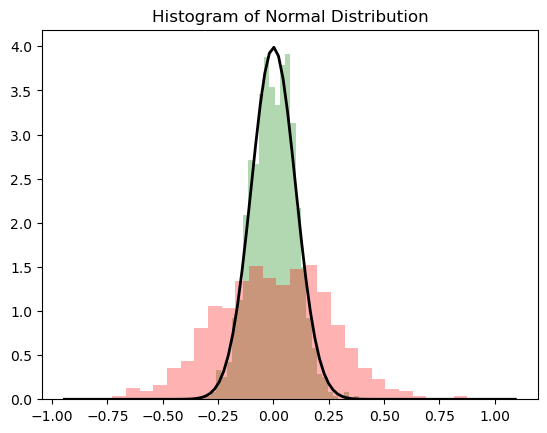

In [103]:
import numpy as np

import matplotlib.pyplot as plt

# Generate random data from a normal distribution
mu, sigma = 0, 0.1  # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)

# Create the histogram
plt.hist(s, bins=30, density=True, alpha=0.3, color='g')
plt.hist(s / (np.abs(s).max()), bins=30, density=True, alpha=0.3, color='r')

# Add a 'best fit' line
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = np.exp(-((x - mu)**2) / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))
plt.plot(x, p, 'k', linewidth=2)

title = "Histogram of Normal Distribution"
plt.title(title)
plt.show()